# Explore data to evaluate if Classification of N delivery time bins works
- Regression approaches have led to crappy models due to made features. (More information in the future may change this)
- Explore if classification will work. 
    - Wait times apart from noise vary from [0, 120 minutes]
    - Let's assume that we have an error tolerance parameter of e minutes. For example we have decided that it is okay to be off by 5 minutes
    - We chop the predict variable range into time bins (categories) that are 5 minutes long and convert this into a classification task
    - We predict to the customer given the input feature vector what is the estimated time frame we can expect their food: 0 - 5 minutes, 5 - 10 minutes, 20 - 25 minutes, 90 - 95 minutes.
    - Caveats: We do not know the impact of a wrong class prediction. How off are we if we get a time bin prediction wrong?
    - The goal of the work in this notebook is to evaluate if the features are strong enough to support a classification task

In [208]:
# read data
import os
import pandas as pd
DATA_READ_PATH = '/Users/calvinperumalla/personal project/Master - Data Scientist, ML Project 6'
DATA_FILE = 'historical_data.csv'
train_data_unfiltered = pd.read_csv(os.path.join(DATA_READ_PATH,DATA_FILE))

In [209]:
# read feature description and load into a dictionary for easy look up ;)
feature_description = pd.read_csv(os.path.join(DATA_READ_PATH, 'feature_description.csv'))[['feature', 'description']].drop_duplicates(subset='feature').to_dict()
index = list(feature_description['description'].keys())
feature_description = {feature_description['feature'][i]:feature_description['description'][i] for i in index}

In [210]:
feature_description

{'actual_delivery_time': ' Timestamp in UTC when the order was delivered to the consumer',
 'created_at': ' Timestamp in UTC when the order was submitted by the consumer to DoorDash. (Note this timestamp is in UTC, but in case you need it, the actual timezone of the region was US/Pacific)',
 'estimated_order_place_duration': ' Estimated time for the restaurant to receive the order from DoorDash (in seconds)',
 'estimated_store_to_consumer_driving_duration': ' Estimated travel time between store and consumer (in seconds)',
 'market_id': ' A city/region in which DoorDash operates, e.g., Los Angeles, given in the data as an id',
 'max_item_price': ' price of the item with the highest cost in the order (in cents)',
 'min_item_price': ' price of the item with the least cost in the order (in cents)',
 'num_distinct_items': ' number of distinct items included in the order',
 'order_protocol': ' a store can receive orders from DoorDash through many modes. This field represents an id denoting t

In [272]:
import datetime
train_data_unfiltered['pick_up_time'] = (pd.to_datetime(train_data_unfiltered['actual_delivery_time']) - pd.to_datetime(train_data_unfiltered['created_at']))
train_data_unfiltered['pick_up_time'] = train_data_unfiltered['pick_up_time'].apply(lambda x: x.total_seconds()) - train_data_unfiltered['estimated_order_place_duration'] - train_data_unfiltered['estimated_store_to_consumer_driving_duration']

In [234]:
# to remove noise
import numpy as np
from tqdm import tqdm
def filter_noise(df, features, noise_threshold=99):
    tmp_df = None
    for f in tqdm(features):
        if tmp_df is None:
            tmp_df = df
        upper = np.percentile(tmp_df[f], noise_threshold)
        tmp_df = tmp_df[tmp_df[f]< upper]
    return tmp_df

In [275]:
print('full size: {}'.format(len(train_data_unfiltered)))
train_data_unfiltered = train_data_unfiltered.dropna(subset=['pick_up_time'])
train_data_unfiltered = train_data_unfiltered[train_data_unfiltered['pick_up_time']>0]
print('after removing noise: {}'.format(len(train_data_unfiltered)))
train_data_unfiltered.fillna(0, inplace=True)

full size: 196829
after removing noise: 196829


In [276]:
# Make Pick up time category
train_data = filter_noise(train_data_unfiltered, ['pick_up_time'])
num_bins = 10
bin_size = (max(train_data['pick_up_time'])/num_bins) + 1
train_data['pick_up_time_bin'] = (train_data['pick_up_time']/bin_size).astype(int)

100%|██████████| 1/1 [00:00<00:00, 58.94it/s]
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [257]:
from matplotlib import pyplot as plt
import numpy as np
def get_bins(series, thresh=99.99, num_bins=20):
    noise_bins = 4
    noise_above = int(np.percentile(series, thresh))
    upper = int(np.max(series))
    bins_lower = list(range(0,noise_above,int(noise_above/(num_bins-noise_bins))))
    #noise_ranges = list(range(noise_above, upper, int((upper-noise_above)/4)))
    return bins_lower
    
def plot_hist(df, features, bin_dict=None):
    bins = bin_dict
    num_features = len(features)
    print('plotting {} plots'.format(num_features))
    if num_features == 1:
        f = plt.hist(df[features[0]], bins=get_bins(df[features[0]]))
        #f = plt.hist(df[features[0]])
        plt.title('histogram of {}'.format(features[0]))
        plt.xlabel(features[0])
        plt.show()
        return
    if num_features == 2:
        plt.figure(figsize=(10, 10))
        plt.subplot(1,2,1)
        f = plt.hist(df[features[0]], bins=get_bins(df[features[0]]))
        plt.title('histogram of {}'.format(features[0]))
        plt.xlabel(features[0])

        plt.subplot(1,2,2)
        f = plt.hist(df[features[1]], bins=get_bins(df[features[1]]))
        plt.title('histogram of {}'.format(features[1]))
        plt.xlabel(features[1])
        plt.show()
        plt.subplots_adjust(bottom=0.1, right=1.2)
        return
    if num_features%3 == 0:
        num_rows = int(num_features/3)
    else:
        num_rows = int(num_features/3) + 1
    fig, axes = plt.subplots(nrows=num_rows, ncols=3)
    fig.subplots_adjust(left=2, right=3)
    fig.set_size_inches(20, 10)
    for ax, index in zip(axes.flatten(), range(len(features))):
        ax.hist(df[features[index]], bins=get_bins(df[features[index]]))
        ax.set(title = 'histogram of {}'.format(features[index]), xlabel=features[index])

In [258]:
def plot_correlation(df, features):
    num_features = len(features)
    print('plotting {} plots'.format(num_features))
    if num_features == 1:
        f = plt.scatter(df[features[0]], df['pick_up_time'])
        #f = plt.hist(df[features[0]])
        plt.title('correlation of {} with pick up time'.format(features[0]))
        plt.xlabel(features[0])
        plt.show()
        return
    if num_features == 2:
        f = plt.scatter(df[features[0]], df['pick_up_time'])
        #f = plt.hist(df[features[0]])
        plt.title('correlation of {} with pick up time'.format(features[0]))
        plt.xlabel(features[0])
        plt.show()

        plt.subplot(1,2,2)
        f = plt.scatter(df[features[1]], df['pick_up_time'])
        #f = plt.hist(df[features[0]])
        plt.title('correlation of {} with pick up time'.format(features[1]))
        plt.xlabel(features[1])
        plt.show()
        #plt.subplots_adjust(bottom=0.1, right=1.2)
        return
    if num_features%3 == 0:
        num_rows = int(num_features/3)
    else:
        num_rows = int(num_features/3) + 1
    fig, axes = plt.subplots(nrows=num_rows, ncols=3)
    fig.subplots_adjust(left=2, right=3)
    fig.set_size_inches(20, 10)
    for ax, index in zip(axes.flatten(), range(len(features))):
        ax.scatter(df[features[index]], df['pick_up_time'])
        ax.set(title = 'correlation of {} with pick up time'.format(features[index]), xlabel=features[index])

In [259]:
from collections import Counter
Counter(train_data['pick_up_time_bin'])

Counter({0: 4371,
         1: 30768,
         2: 51302,
         3: 45059,
         4: 29160,
         5: 16642,
         6: 8966,
         7: 4736,
         8: 2542,
         9: 1313})

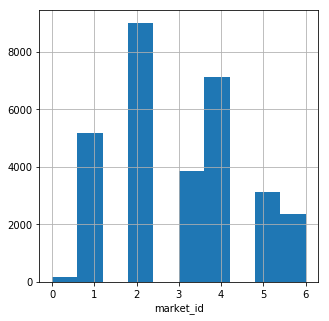

In [260]:
train_data = train_data.fillna(value=0)
# quick delivery
quick_bin = train_data[train_data['pick_up_time_bin']==1]

# late delivery
late_bin = train_data[train_data['pick_up_time_bin']==2]

from matplotlib import pyplot as plt
feature = 'market_id'
plt.figure(figsize=(5, 5))
plt.hist(quick_bin[feature])
plt.xlabel(feature)
plt.grid()
plt.show()

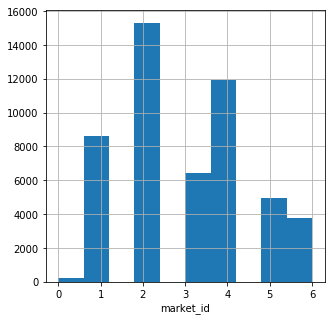

In [261]:
plt.figure(figsize=(5, 5))
plt.hist(late_bin[feature])
plt.xlabel(feature)
plt.grid()
plt.show()

## Approach: Random forest
- Throw all features at it and see what happens

In [262]:
train_data = train_data.drop(labels=['actual_delivery_time', 'created_at'], axis=1)
train_data['store_primary_category'] = train_data['store_primary_category'].astype('category')
train_data.dtypes

market_id                                        float64
store_id                                           int64
store_primary_category                          category
order_protocol                                   float64
total_items                                        int64
subtotal                                           int64
num_distinct_items                                 int64
min_item_price                                     int64
max_item_price                                     int64
total_onshift_dashers                            float64
total_busy_dashers                               float64
total_outstanding_orders                         float64
estimated_order_place_duration                     int64
estimated_store_to_consumer_driving_duration     float64
pick_up_time                                     float64
pick_up_time_bin                                   int64
dtype: object

In [263]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train_data['store_primary_category'])
train_data['store_primary_encoded'] = le.transform(train_data['store_primary_category'])
train_data = train_data.drop('store_primary_category', axis=1)

In [264]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

kfold = KFold(n_splits=5)
model_predictions = {}
model_performance = {}
model_run_index = 0
X = train_data.drop(['pick_up_time', 'pick_up_time_bin'], axis=1)
y = train_data[['pick_up_time_bin']]
rand_forest = RandomForestClassifier()
for train_index, test_index in tqdm(kfold.split(X)):
    model_run_index += 1
    train_x = X.iloc[train_index]
    train_y = y.iloc[train_index]
    #print(any([any(np.isnan(inst)) for inst in train_x]))
    #print(any([np.isnan(inst) for inst in train_y]), 'y')
    model = rand_forest.fit(train_x, train_y)
    test_x = X.iloc[test_index]
    test_y = y.iloc[test_index]
    predictions = model.predict(test_x)
    model_name = 'run_{}'.format(model_run_index)
    model_predictions[model_name] = zip(test_y.values, predictions)
    model_performance[model_name] = model.score(test_x, test_y)

0it [00:00, ?it/s]/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
5it [00:19,  3.98s/it]


In [265]:
# r2 score 
model_performance

{'run_1': 0.24923021656573952,
 'run_2': 0.25171918300318175,
 'run_3': 0.2524633069896336,
 'run_4': 0.25069280509083447,
 'run_5': 0.25311128788073184}

In [266]:
total = 0
mispredicitions = []
for true, pred in model_predictions['run_5']:
    total += 1
    if true != pred:
        mispredicitions.append(true-pred)
        
        
print('bin size in minutes: {}'.format(bin_size/60.0))
print('total_accuracy: {}'.format(1.0*(total - len(mispredicitions))/total))
print('total predictions {}'.format(total))
print('total number of mis predictions: {}'.format(len(mispredicitions)))
mis_np = np.array(mispredicitions)
early = mis_np[mis_np>0]
late = mis_np[mis_np<0]
print('total number of early mispredictions:{}'.format(len(early)))
print('total number of late mispredictions:{}'.format(len(late)))
early_avg = sum(early)/len(early) * (bin_size * 1/60.0) 
late_avg = -1* (sum(late)/len(late) * (bin_size * 1/60.0))
print('avg error in early errors: {} minutes'.format(early_avg))
print('avg error in late errors: {} minutes'.format(late_avg))

bin size in minutes: 9.27333333333
total_accuracy: 0.253111287881
total predictions 38971
total number of mis predictions: 29107
total number of early mispredictions:18672
total number of late mispredictions:10435
avg error in early errors: 18.5466666667 minutes
avg error in late errors: 18.5466666667 minutes


In [267]:
zip(model.feature_importances_, X.columns)

[(0.027250146762249634, 'market_id'),
 (0.0991134150493288, 'store_id'),
 (0.03451794662672818, 'order_protocol'),
 (0.031756002526798846, 'total_items'),
 (0.11426159504147466, 'subtotal'),
 (0.02926569996931654, 'num_distinct_items'),
 (0.095576920399998, 'min_item_price'),
 (0.0960374381337213, 'max_item_price'),
 (0.08801179989278705, 'total_onshift_dashers'),
 (0.0823032727792441, 'total_busy_dashers'),
 (0.09832438880584024, 'total_outstanding_orders'),
 (0.01027640785295142, 'estimated_order_place_duration'),
 (0.12155361703516057, 'estimated_store_to_consumer_driving_duration'),
 (0.07175134912440059, 'store_primary_encoded')]

## Approach: Neural Network


In [268]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(alpha=1e-5, activation='logistic', hidden_layer_sizes=(100, 3))

In [269]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

kfold = KFold(n_splits=5)
model_predictions = {}
model_performance = {}
model_run_index = 0
X = train_data.drop(['pick_up_time', 'pick_up_time_bin'], axis=1)
y = train_data[['pick_up_time_bin']]
rand_forest = RandomForestClassifier()
for train_index, test_index in tqdm(kfold.split(X)):
    model_run_index += 1
    train_x = X.iloc[train_index]
    train_y = y.iloc[train_index]
    #print(any([any(np.isnan(inst)) for inst in train_x]))
    #print(any([np.isnan(inst) for inst in train_y]), 'y')
    model = clf.fit(train_x, train_y)
    test_x = X.iloc[test_index]
    test_y = y.iloc[test_index]
    predictions = model.predict(test_x)
    model_name = 'run_{}'.format(model_run_index)
    model_predictions[model_name] = zip(test_y.values, predictions)
    model_performance[model_name] = model.score(test_x, test_y)

5it [02:34, 30.94s/it]


In [270]:
# r2 score 
model_performance

{'run_1': 0.2813558452222108,
 'run_2': 0.2817150774915324,
 'run_3': 0.2919275377193883,
 'run_4': 0.28676998870984294,
 'run_5': 0.28998486053732264}

In [271]:
total = 0
mispredicitions = []
for true, pred in model_predictions['run_5']:
    total += 1
    if true != pred:
        mispredicitions.append(true-pred)
        
        
print('bin size in minutes: {}'.format(bin_size/60.0))
print('total_accuracy: {}'.format(1.0*(total - len(mispredicitions))/total))
print('total predictions {}'.format(total))
print('total number of mis predictions: {}'.format(len(mispredicitions)))
mis_np = np.array(mispredicitions)
early = mis_np[mis_np>0]
late = mis_np[mis_np<0]
print('total number of early mispredictions:{}'.format(len(early)))
print('total number of late mispredictions:{}'.format(len(late)))
early_avg = sum(early)/len(early) * (bin_size * 1/60.0) 
late_avg = -1* (sum(late)/len(late) * (bin_size * 1/60.0))
print('avg error in early errors: {} minutes'.format(early_avg))
print('avg error in late errors: {} minutes'.format(late_avg))

bin size in minutes: 9.27333333333
total_accuracy: 0.289984860537
total predictions 38971
total number of mis predictions: 27670
total number of early mispredictions:17759
total number of late mispredictions:9911
avg error in early errors: 18.5466666667 minutes
avg error in late errors: 18.5466666667 minutes


In [277]:
train_data.dtypes

market_id                                       float64
created_at                                       object
actual_delivery_time                             object
store_id                                          int64
store_primary_category                           object
order_protocol                                  float64
total_items                                       int64
subtotal                                          int64
num_distinct_items                                int64
min_item_price                                    int64
max_item_price                                    int64
total_onshift_dashers                           float64
total_busy_dashers                              float64
total_outstanding_orders                        float64
estimated_order_place_duration                    int64
estimated_store_to_consumer_driving_duration    float64
pick_up_time                                    float64
pick_up_time_bin                                

In [279]:
test = train_data[['created_at', 'store_id', 'pick_up_time']]
test_2 = test[test['store_id'] == 3937]
display(test_2)

,created_at,store_id,pick_up_time
102815,2015-02-11 19:20:27,3937,4136.0
102816,2015-01-31 17:24:58,3937,1670.0
102817,2015-01-27 03:06:12,3937,3245.0
102818,2015-02-09 00:23:55,3937,1967.0
102819,2015-01-29 01:36:41,3937,2869.0
102820,2015-02-13 20:54:48,3937,2485.0
102821,2015-01-31 04:16:55,3937,2212.0
102822,2015-02-18 03:04:59,3937,2120.0
102823,2015-02-11 21:00:52,3937,2031.0
102824,2015-01-26 19:54:17,3937,2786.0


In [283]:
_ , times = zip(*sorted(zip(test_2['created_at'], test_2['pick_up_time']), key=lambda x:x[0]))

In [293]:
sorted(zip(test_2['created_at'], test_2['pick_up_time']), key=lambda x:x[0])

[('2015-01-21 16:23:04', 3580.0),
 ('2015-01-21 19:20:27', 4607.0),
 ('2015-01-21 19:25:38', 4825.0),
 ('2015-01-21 19:37:57', 3748.0),
 ('2015-01-21 20:05:55', 2051.0),
 ('2015-01-21 20:09:48', 3137.0),
 ('2015-01-21 20:21:54', 1437.0),
 ('2015-01-21 20:24:39', 3136.0),
 ('2015-01-21 22:14:19', 2542.0),
 ('2015-01-21 22:25:07', 2048.0),
 ('2015-01-21 23:57:16', 2094.0),
 ('2015-01-22 00:09:25', 1765.0),
 ('2015-01-22 00:23:45', 2246.0),
 ('2015-01-22 00:45:57', 2527.0),
 ('2015-01-22 00:51:21', 3491.0000000000005),
 ('2015-01-22 01:00:46', 2678.0),
 ('2015-01-22 01:14:08', 2749.0000000000005),
 ('2015-01-22 01:39:40', 3871.0),
 ('2015-01-22 02:09:06', 4643.0),
 ('2015-01-22 02:17:33', 3574.0),
 ('2015-01-22 02:36:05', 1868.0),
 ('2015-01-22 02:37:29', 3325.0000000000005),
 ('2015-01-22 02:42:38', 2389.0),
 ('2015-01-22 02:58:06', 2349.0),
 ('2015-01-22 02:59:07', 2936.0000000000005),
 ('2015-01-22 03:05:09', 1932.0),
 ('2015-01-22 03:06:29', 2195.0),
 ('2015-01-22 03:11:17', 2868.0000

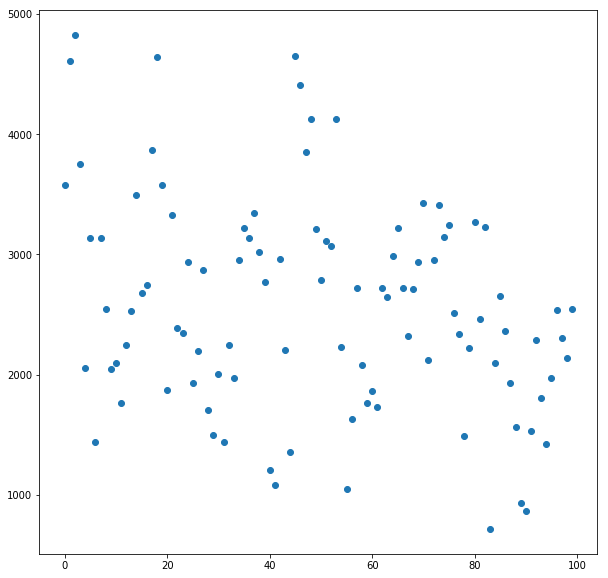

In [292]:
plt.figure(figsize=(10, 10))
#plt.scatter(range(len(times)), times)
plt.scatter(range(100), times[:100])
plt.show()